# Processamento e Segmentação de Imagens DICOM em Python

### Introdução

Atualmente, as imagens resultantes dos exames de Tomografia Computadorizada (TC) podem ser armazenadas em computadores para posteriormente serem visualizadas por softwares específicos. [...]. O formato <i>Digital Imaging and Communications in Medicine</i> (DICOM), é utilizado na maioria dos aparelhos que produzem esse tipo de exames. Ele foi proposto para permitir o armazenamento tanto da imagem do exame quanto outros dados do próprio exame e do paciente examinado [1].

Tradicionalmente, o resultado da Tomografia Computadorizada mostra imagens de cortes transversais (fatias) da estrutura analisada. Em um exame, essas fatias estão distanciadas umas das outras de alguns milímetros (mm), geralmente entre 1 e 10 mm. A estrutura em 3D é obtida a partir da justaposição dessas fatias e do preenchimento do espaço vazio entre elas, utilizando um processo de interpolação em 3D. Geralmente, para se obter uma visualização ao em 3D de alta qualidade e necessário a obtenção de fatias próximas umas das outras, aumentando a exposição do paciente ao raio-X [2].

![title](imagens/imagem01.jpg)

A visualização em 3D do resultado de um exame de tomografia computadorizada (TC) aumenta a confiabilidade do diagnóstico médico e, por consequência, a eficácia do tratamento. Ela auxilia no processo de análise e diagnóstico, pois dispensa o médico da tarefa mental de reconstruir as estruturas internas do corpo humano a partir das fatias 2D [2].

![title](imagens/imagem02.jpg)

### Segmentação

Com o aperfeiçoamento das técnicas de aquisição de imagens médicas, tais como a Tomografia Computadorizada e a Ressonância Magnética, a capacidade e a fidelidade do diagnóstico por imagens foram ampliadas.Um banco de imagens médicas pode se beneficiar de técnicas de processamento de imagens para classificar as imagens e permitir o reconhecimento de padrões. A segmentação é uma técnica usada neste tipo de aplicação, pois permite isolar regiões da imagem que possuem características em comum, ajudando a classificá-las de acordo com as estruturas que a compõem [4].

![title](imagens/imagem05.jpg)



### Observação sobre o Código

Alguns dos códigos usados aqui são adaptados dos colaboradores da Kaggle (como a equipe de dados de Guido Zuidhorf, Booze Allen Hamilton e Howard Chen [5]) que compartilham generosamente seu trabalho. Eu fiz modificações para esclarecer o que acontece em cada etapa usando mais imagens e código adicional ou simplificado.

### Objetivos deste projeto

<ol>
    <li>Carregar dados com <b>pydicom</b>.</li>
    <li>Utilização de gráficos 1D (histograma), 2D e 3D para exibir imagens DICOM.</li>
    <li>Dados pré-processados para o aprendizado de máquinas</li>
    <ol>
        <li>Conversão do valor do pixel para unidades de Hundsfeld</li>
        <li>Resampling por isotropia</li>
        <li>Segmentação</li>
        <li>Aplicação da máscara</li>
    </ol>
</ol>

### Requisitos iniciais

Para início deste projeto, será utilizado imagens DICOM brutas (sem modificações ou processamento). Será extraído dados das imagens DICOM com matrizes juntamente com <b><i>numpy</i></b>, e em seguida, executar algumas operações de baixo nível para normalizar os dados.

O restante do projeto é dedicado a visulizar os dados em 1D (por histograma), 2D e 3D. Por fim serão criadas máscaras de segmentação.

Caso você esteja utilizando o Anaconda, você terá acesso a quase todos os pacotes necessários para este projeto. A exceção é o pacote <b><i>dicom</i></b>, para fazer isso a maneira mais fácil é usar a <b><i>pip</i></b> a partir da linha de comando:

<span style="background-color: #4682B4"><font color="white">pip install dicom</font></span>

Para executar os gráficos 3D, será utilizado a versão gratuita do <b><i>plotly</i></b> no modo offline que o WebGL para tornar a visualização interativa, <b><i>plotly</i></b> e <b><i>scikit-image</i></b>(versão 0.13 ou superior) podem ser instalados usando o conda:

<span style="background-color: #4682B4"><font color="white">conda install plotly</font></span>

<span style="background-color: #4682B4"><font color="white">conda scikit-image</font></span>

### Dataset

O dataset que será utilizado neste projeto está localizado em um <a href="https://www.kaggle.com/c/data-science-bowl-2017"><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">conjunto de dados Kaggle Data Science Bowl 2017</font></font></a>. O mesmo dataset é composto por uma pilha de imagens DICOM.

Vale ressaltar que o dataset completo do stage 1 (stage1.7z) possui 66.88 GB (Gigabytes) de espaço de armazenamento, mas, para viabilizar este projeto, será utilizado uma parte deste conjunto de dados que também foi disponibilizada separadamente (sample_images.7z) que ocupa o espaço de armazenamento de 781.39 MB (Megabytes)

Ainda assim, poucos exames contidos no "sample_images" foram utilizados neste projeto, pois o Github não trabalha bem com projetos de tamanhos grandes, acima de 1 GB e com arquivos maiores de 100 MB. Então foram mantidos apenas 6 exames de pacientes distintos para serem utilizados neste projeto. Caso haja interesse em todos, acesse o link do Kaggle logo acima.

### Importando

In [1]:
# %reload_ext signature
# %matplotlib inline

import numpy as np
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# esta biblioteca foi realocada
# from plotly.tools import FigureFactory as FF
from plotly import figure_factory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [2]:
# Selecionando a pasta do exame médico de tomografia computadorizada do paciente
data_path = "Kaggle DICOM/sample_images/0a099f2549429d29b32f349e95fb2244"

# Criação de uma pasta para os arquivos de saída (máscaras e imagens processadas)
output_path = working_path = "Output/"

# Importando todos os arquivos DICOM da pasta de exame médico do paciente
g = glob(data_path + '/*.dcm')

# Printando os 5 primeiros nomes dos arquivos dicom que foram verificados na pasta do paciente
print ("Total de %d Imagens DICOM.\n5 primeiros nomes de arquivos:" % len(g))
print ("\n".join(g[:5]))

Total de 128 Imagens DICOM.
5 primeiros nomes de arquivos:
Kaggle DICOM/sample_images/0a099f2549429d29b32f349e95fb2244\002b950106f7054b5241bc5473f674c1.dcm
Kaggle DICOM/sample_images/0a099f2549429d29b32f349e95fb2244\0193890c0ee458aad077e7fe0acf7185.dcm
Kaggle DICOM/sample_images/0a099f2549429d29b32f349e95fb2244\036ff5dd423645ac301d071a11f62a79.dcm
Kaggle DICOM/sample_images/0a099f2549429d29b32f349e95fb2244\05274144af0f6c62e2360abc11ac3c80.dcm
Kaggle DICOM/sample_images/0a099f2549429d29b32f349e95fb2244\0605b1e8f2f329ccdc761d1ff82a993b.dcm


### Explicando as funções

<b>load_scan</b> carrega as imagens DICOM da pasta dentro de uma lista de manipulação.

Os valores do voxel nas imagens estão em formato bruto (raw). A função <b> get_pixels_hu</b> converte os valores brutos em <a href="https://en.wikipedia.org/wiki/Hounsfield_scale">Escala de unidade de Houndsfeld</a>

In [3]:
#      
# Loop para percorrer os arquivos de imagens e armazenar tudo em uma lista
# 

# carrega as imagens DICOM da pasta dentro de uma lista de manipulação
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

# Converte os valores brutos em Escala de unidade de Houndsfeld
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Converter para int16 
    # Pois os valores devem ser sempre baixos, abaixo de 32K
    image = image.astype(np.int16)

    # Defina pixels fora da varredura para 1 
    # A intercepção geralmente é -1024, então o ar é aproximadamente 0 
    image[image == -2000] = 0
    
    # Converter para unidades Hounsfield (HU) 
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# Main
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

Salvando o novo conjunto de dados no disco, para não precisar reprocessar a pilha sempre

In [4]:
# Salvar o id do exame
posicaoCaractere = (len(data_path)) - 1
flagDeBarra = False
idDoExame = ""

while(flagDeBarra == False):
    if(data_path[posicaoCaractere] != "/"):
       idDoExame = data_path[posicaoCaractere] + idDoExame
       posicaoCaractere = posicaoCaractere - 1
    else:
       flagDeBarra = True

np.save(output_path + "fullimages_%s.npy" % (idDoExame), imgs)

### Os valores dos pixels em imagens médicas (DICOM)

A primeira coisa que devemos fazer é verificar se as unidades de Houndsfeld são adequadamente dimensionadas e representadas.

Os HU são úteis porque estão padronizados em todas as tomografias, independentemente do número absoluto de fótons capturados pelo detector do scanner. Se você precisar de uma atualização, aqui está uma lista rápida de alguns úteis, provenientes da Wikipedia.

<table style="width:50%">
    <tr>
        <th>Substância</th>
        <th>HU</th> 
    </tr>
    <tr>
        <td>Ar</td> 
        <td>-1000</td>
    </tr>
    <tr>
        <td>Pulmão</td> 
        <td>-500</td>
    </tr>
    <tr>
        <td>Gordura</td> 
        <td>-100 a -50</td>
    </tr>
    <tr>
        <td>Água</td> 
        <td>0</td>
    </tr>
    <tr>
        <td>Sangue</td> 
        <td>+30 a +70</td>
    </tr>
    <tr>
        <td>Músculo</td> 
        <td>+10 a +40</td>
    </tr>
    <tr>
        <td>Fígado</td> 
        <td>+40 a +60</td>
    </tr>
    <tr>
        <td>Osso</td> 
        <td>+700 (osso esponjoso) para +3000 (osso cortical)</td>
    </tr>
</table>

### Criação de um histograma de todos os dados do voxel no estudo

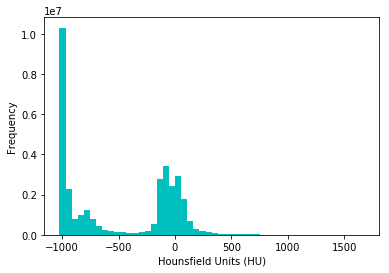

In [5]:
file_used=output_path+"fullimages_%s.npy" % idDoExame
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### Conclusões do Histograma

O histograma sugere que:

<ul>
  <li>Há muito ar (pixels de valor -1000).</li>
  <li>Existe um pulmão (pixels próximos ao valor de -500).</li>
  <li>Há uma boa quantidade de tecidos moles, músculo, fígado e gordura (pixels com valor entre -100 e 60).</li>
  <li>Há fragmentos pequenos de ossos, visto que há uma pequena porção entre 700 e 1000.</li>
</ul>

### Exibindo a pilha de imagens

Não temos muita tela, então irá haver um salto de 3 fatias (slices) para obter um olhar representativo.

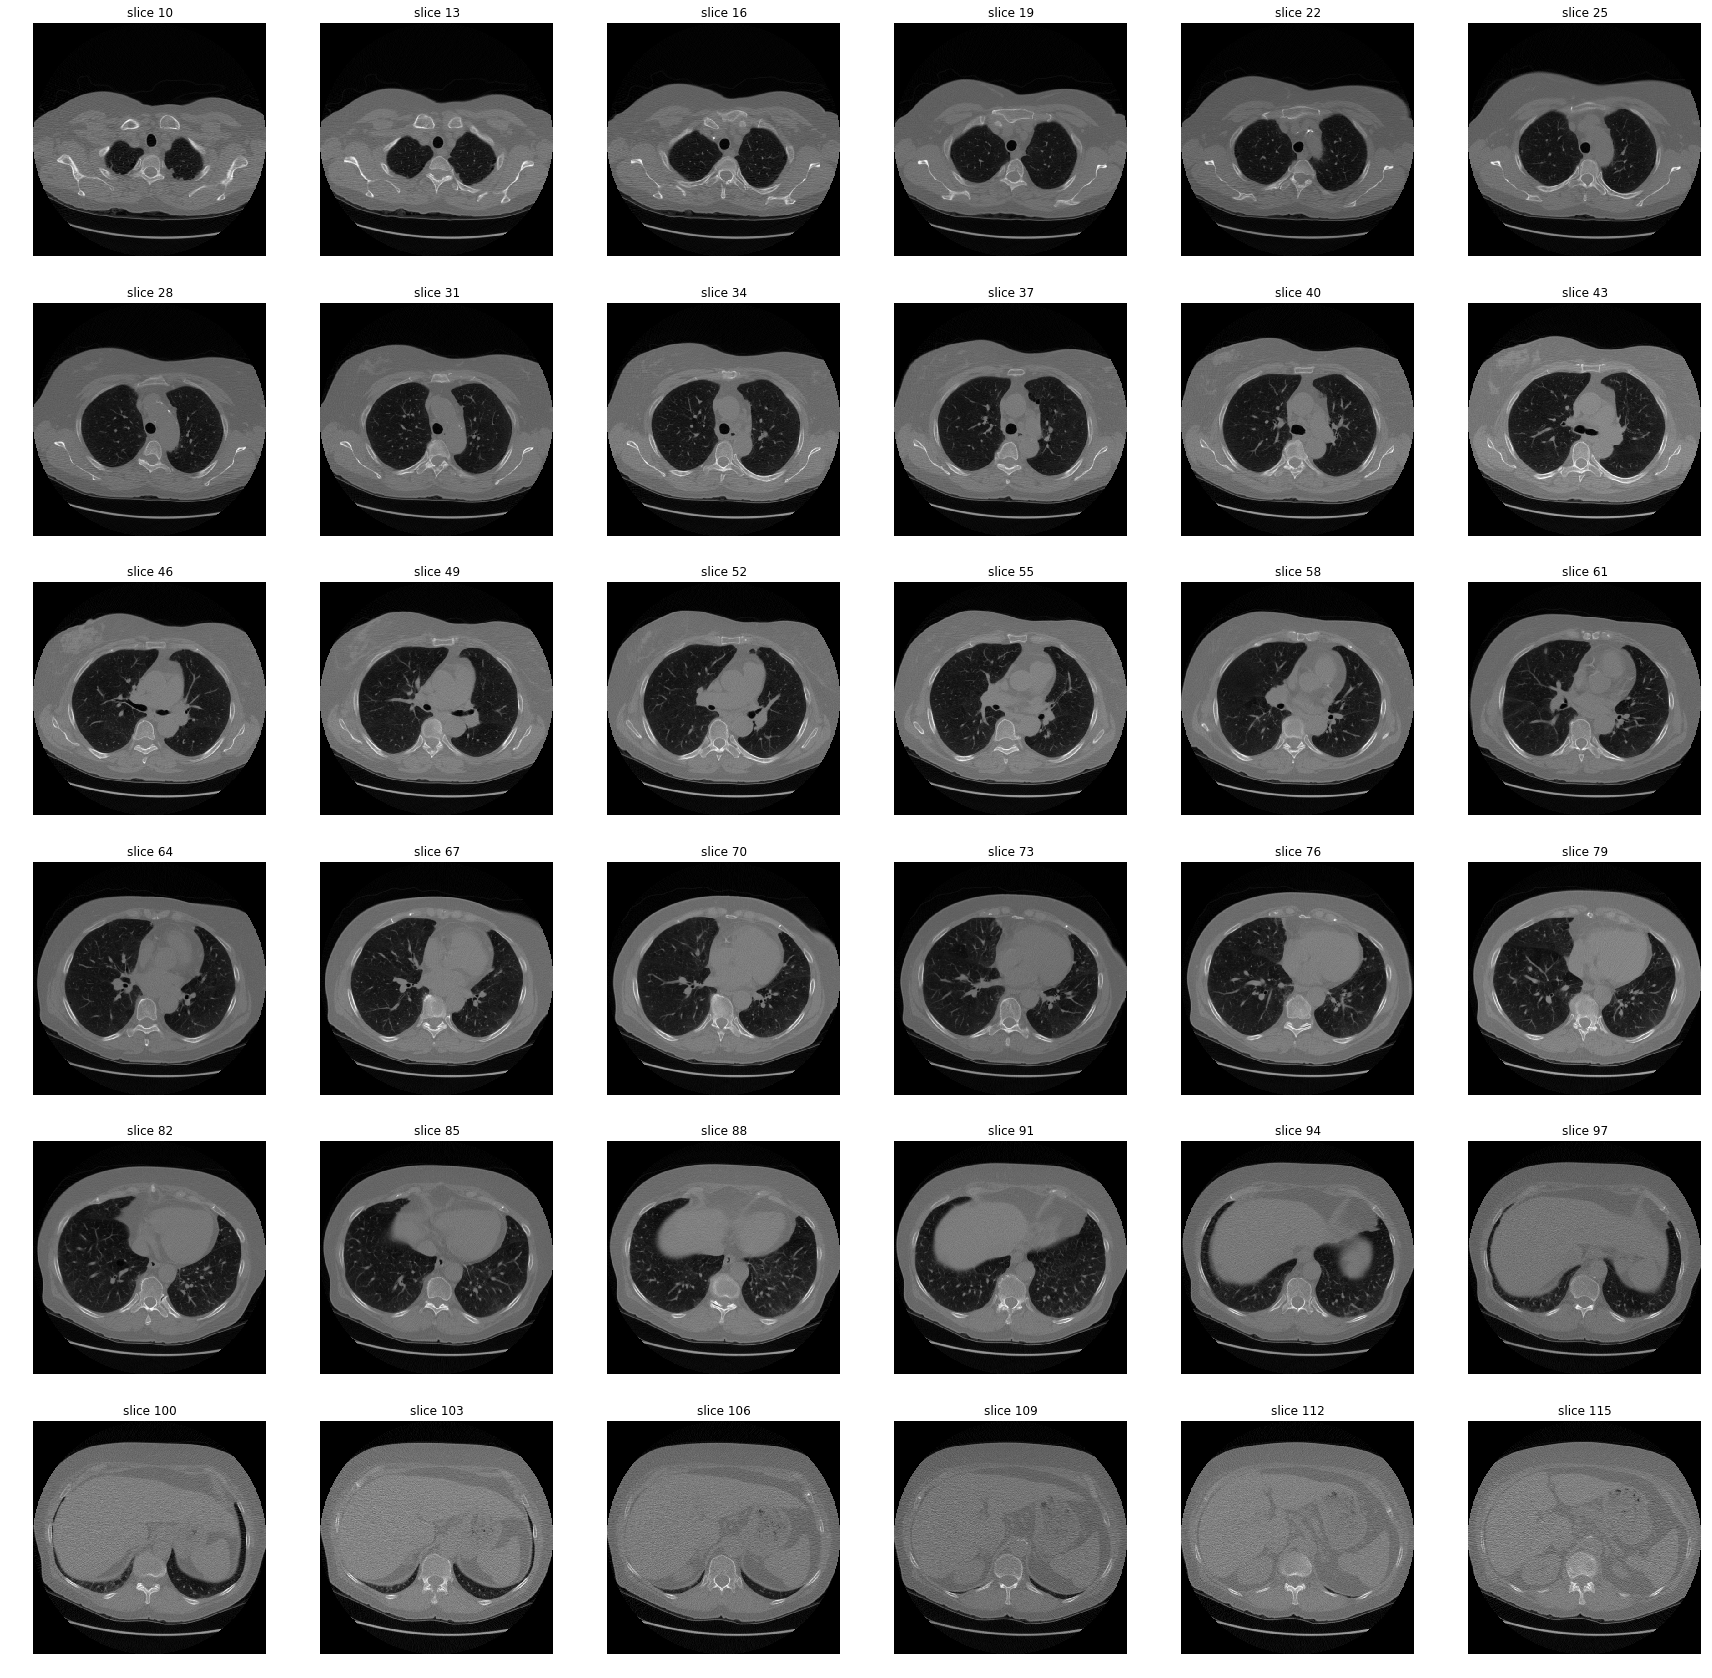

In [6]:
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(idDoExame))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[30,30])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

### Resampling

Embora tenhamos cada fatias individuais, não é imediatamente claro quão grosso é cada fatia.
Felizmente, isso está no cabeçalho DICOM.

In [7]:
print ("Espessura da Fatia (Slice Thickness): %f" % patient[0].SliceThickness)
print ("Espaçamento de Pixel (Pixel Spacing) (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Espessura da Fatia (Slice Thickness): 2.500000
Espaçamento de Pixel (Pixel Spacing) (row, col): (0.677734, 0.677734) 


In [8]:
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(idDoExame))

def resample(image, scan, new_spacing=[1,1,1]):
    # Determinar o espaçamento entre pixels atual
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print ("Antes do resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print ("Depois do resampling\t", imgs_after_resamp.shape)

Antes do resampling	 (128, 512, 512)
Depois do resampling	 (320, 347, 347)


### Traçado 3D

Ter dados isotrópicos é útil porque nos dá uma sensação da dimensão Z. Isso significa que agora temos informações suficientes para traçar a imagem DICOM no espaço 3D. Para chutes, nos concentraremos em renderizar apenas os ossos.

O algoritmo de <a href="https://en.wikipedia.org/wiki/Marching_cubes">Marching Cubes</a> é usado para gerar uma malha 3D do conjunto de dados. O modelo plotly utilizará um <b>step_sizelimite</b> de voxel mais alto com o menor para evitar a avaria do navegador da Web

In [9]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposição da Superfície")
    p = image.transpose(2,1,0)
    
    print ("Calculando a superfície")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Desenhando")
    
    # Crie um mapcolor de cores separadas entre os eixos. 
    #colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Visualização Interativa")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Desenhando")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` para gerar uma coleção de triângulos
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor([0.7, 0.7, 0.7])
    plt.show()

Transposição da Superfície
Calculando a superfície
Desenhando


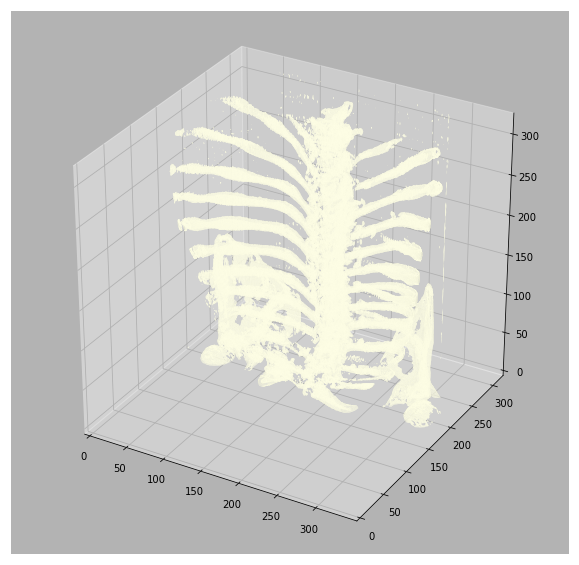

In [13]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

### Segmentação e Aprendizagem de Máquina

Se você está interessado em Tomografia Computadorizada (TC) de tórax porque está interessado em descobrir câncer de pulmão, você não está sozinho.

Os algoritmos de aprendizagem de máquinas funcionam muito melhor quando você pode definir de forma restrita o que está procurando. Uma maneira de fazer isso é criando diferentes modelos para diferentes partes de uma TC de tórax. Por exemplo, uma rede convolutiva para pulmões seria melhor do que uma rede de propósito geral para todo o baú.

Portanto, muitas vezes é útil pré-processar os dados da imagem detectando automaticamente os limites envolvendo um volume de interesse.

O código abaixo faz:
<ul>
    <li>Padronizar o valor do pixel subtraindo a média e dividindo pelo desvio padrão</li>
    <li>Identificar o limite apropriado criando 2 clusters de KMeans comparando centrados em tecido mole e osso, e outro com pulmão e ar.</li>
    <li>Usando Erosão e Dilatação, que tem o efeito de remover pequenas características como vasos pulmonares ou barulho</li>
    <li>Identifique cada região distinta como etiquetas de imagem separadas (pense na varinha mágica no Photoshop)</li>
    <li>Usando caixas de delimitação para cada rótulo de imagem para identificar quais representam o pulmão e quais representam "todo o resto"</li>
    <li>Crie as máscaras para campos pulmonares.</li>
    <li>Aplique máscara na imagem original para apagar voxels fora dos campos pulmonares.</li>
</ul>



In [10]:
#Padronizar os valores dos pixels
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Encontrar o valor médio do pixel perto dos pulmões
    # para renormalizar imagens processadas
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # Para melhorar a detecção das bordas do pulmão
    # procura-se os pixels de underflow e overflow na imagem
    img[img==max]=mean
    img[img==min]=mean
    
    #
    # Usando Kmeans para separar primeiro plano (tecido macio / osso) e fundo (pulmão / ar)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold da imagem

    # Primeiro, faça a erosão dos elementos mais finos, então dilate para incluir alguns pixels que cercam o pulmão
    # Pois não queremos atingir acidentalmente o pulmão.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Diferentes labels são visualizadas em diferentes cores
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  Depois que apenas os pulmões são deixados, nós fazemos outra grande dilatação
    #  afim de preencher e finalizar a máscara do pulmão

    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # uma última dilatação

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("Depois da Erosão e Dilatação")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Labes coloridas")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Máscara final")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Aplicando a máscara na imagem original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

Fatia da Tomografia número: 0


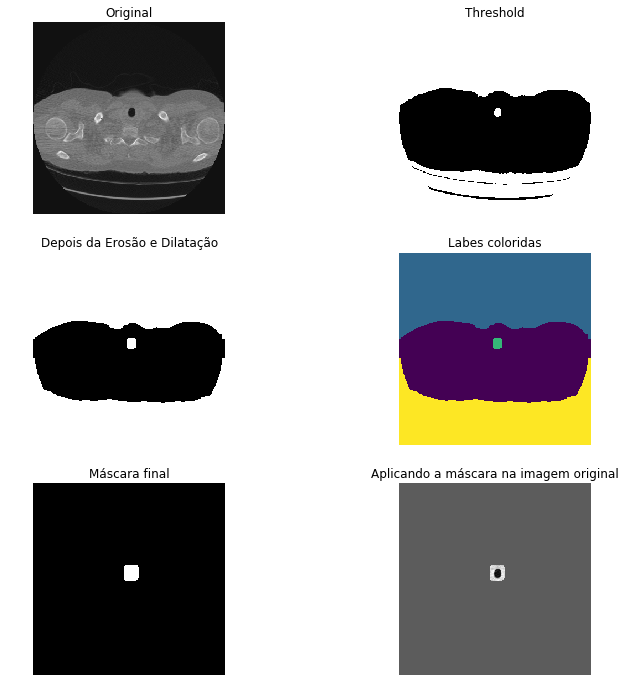

Fatia da Tomografia número: 50


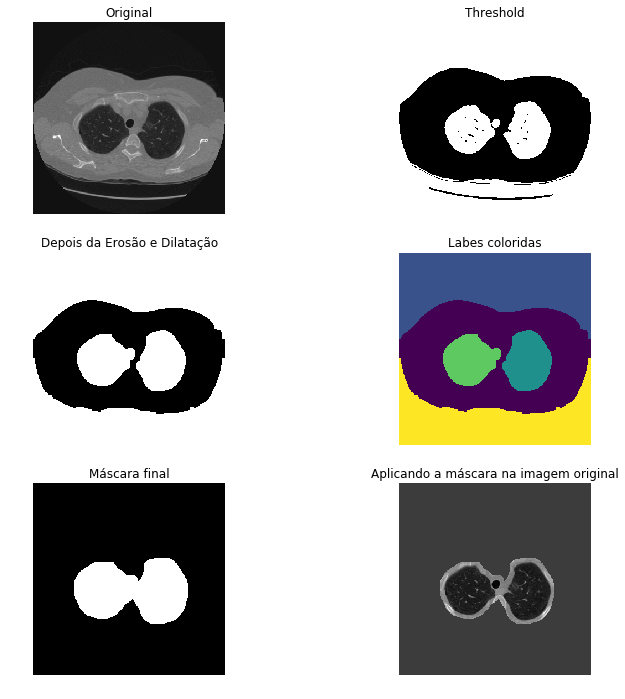

Fatia da Tomografia número: 100


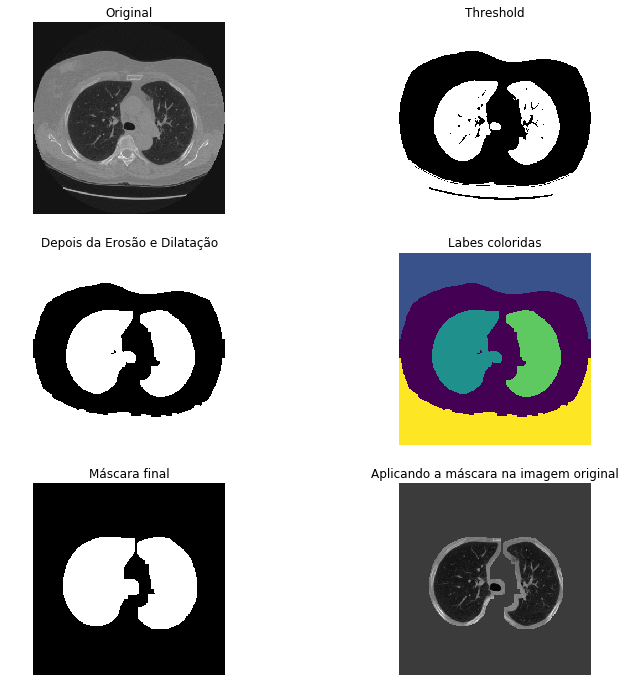

Fatia da Tomografia número: 150


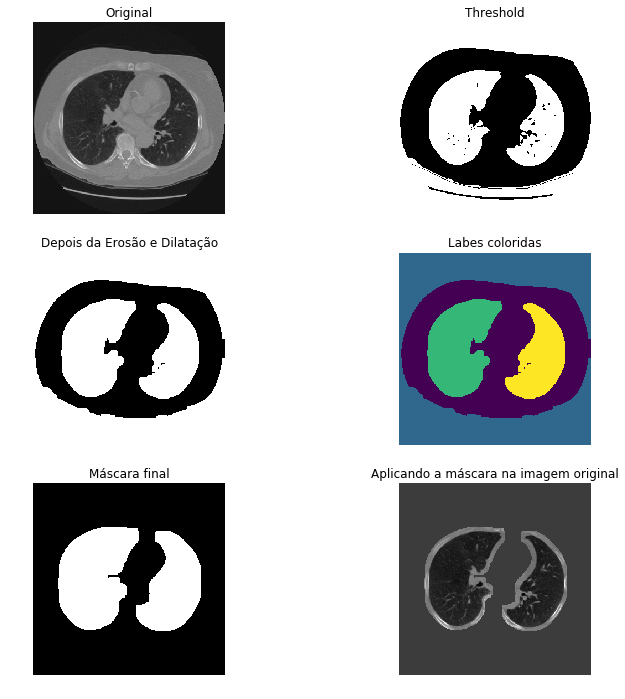

Fatia da Tomografia número: 200


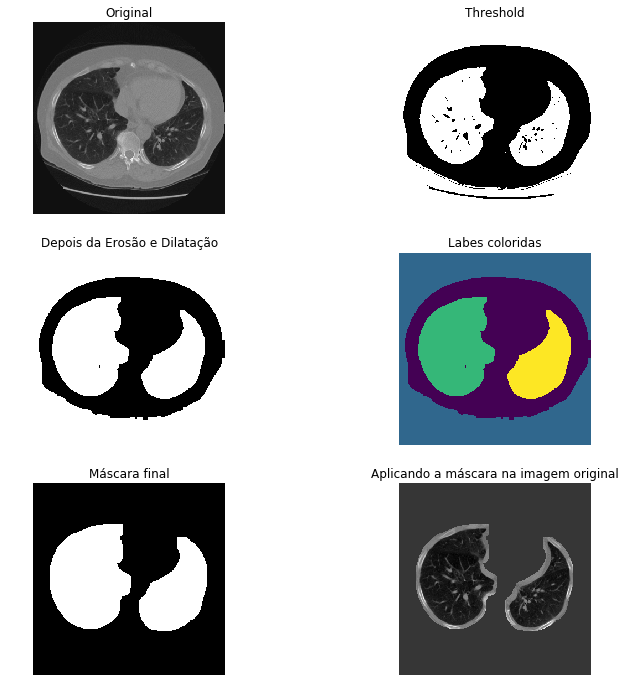

Fatia da Tomografia número: 250


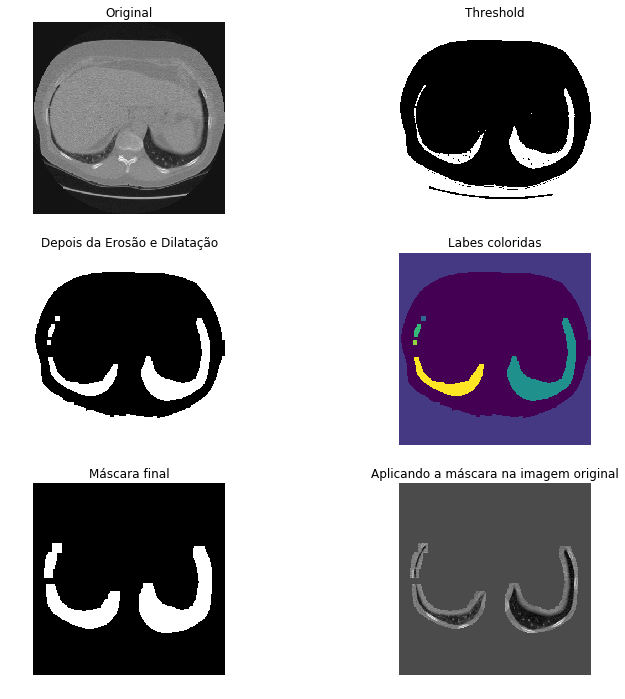

Fatia da Tomografia número: 300


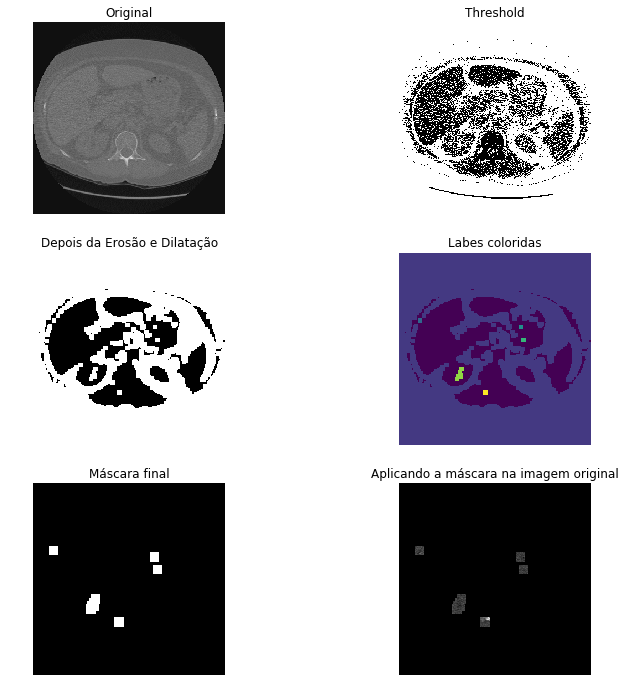

In [11]:
for fatiaTomografia in range (0, len(imgs_after_resamp), 50):
    print("Fatia da Tomografia número: %d" %fatiaTomografia)
    img = imgs_after_resamp[fatiaTomografia]
    make_lungmask(img, display=True)
    print("===================================================")

In [12]:
# Salvando os dados processados
np.save(output_path + "maskedimages_%s.npy" % (idDoExame), imgs)

### Conclusão

Se aplicássemos um algoritmo de aprendizagem de máquina à pilha de imagens, o algoritmo teria um tempo muito mais fácil para identificar uma lesão pulmonar primária.

Nem sempre a clusterização irá proporcionar resultados satifatórios, como o deste projeto, podendo remover em alguma fatia da tomografia ou ressonância magnética, algum pedaço de algum objeto que está sendo segmentado.

Desvantagens de usar esta máscara é que você pode não detectar a doença hilar / perihilar no pulmão.

### Trabalhos Futuros

Com o aprendizado deste projeto, é possível utilizar parte do código para segmentar outros tipos de órgãos, ossos do corpo ou até objetos (artefatos metálicos)

### Referências Bibliográficas

[1] PIRES, Sandrerley Ramos. <b>Interpolação tridimensional de imagens de tomografia computadorizada utilizando equações diferenciais parciais</b>. 2007. 64 f. Dissertação (Mestrado em Engenharias) - Universidade Federal de Uberlândia, Uberlândia, 2007.

[2] PIRES, Sandrerley Ramos; FLORES, Edna Lúcia; BARCELOS, Celia Aparecida Zorzo Barcelos. <b>Visualizacão em 3D de Tomografia Computadorizadas Utilizando Equações de Transporte e de Difusão</b>.

[3] YAZDI, Mehran; LARI, Meghdad Asadi; BERNIER, Gaston; BEAULIEU. <b>An opposite view data replacement approach for reducing artifacts due to metallic dental objects</b>.

[4] MEGDALIA, Diego R.; MANSSOUR, Isabel Harb. <b>Segmentação de Imagens Médicas Baseada no Uso das Bibliotecas ITK e VTK</b>. 2006. Pontifícia Universidade Católica do Rio Grande do Sul, Porto Alegre.

[5] CHEN, Howard. <b>DICOM Processing and Segmentation in Python</b>.